<a href="https://colab.research.google.com/github/sylpx/Deep-Learning-Tugas-2/blob/main/DeepLearningNielTugas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Install dan import library
!pip install gdown --quiet
!pip install tensorflow --quiet

import tensorflow as tf
import gdown
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import matplotlib.pyplot as plt

In [2]:
# 2. Upload dataset zip
file_id = "13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

gdown.download(url, "DATASETGAMBAR.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO
From (redirected): https://drive.google.com/uc?export=download&id=13OMC0kC0ibt-cqm1wfpchuV5LZUFHZAO&confirm=t&uuid=5a0a98cc-5f1a-41ae-932c-84b123db9da1
To: /content/DATASETGAMBAR.zip
100%|██████████| 38.8M/38.8M [00:00<00:00, 49.1MB/s]


'DATASETGAMBAR.zip'

In [3]:
# 3. Ekstrak dataset
import zipfile

with zipfile.ZipFile("DATASETGAMBAR.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [4]:
import shutil
import random
from pathlib import Path

# Path awal dataset setelah diekstrak
original_dataset_dir = Path("dataset/DATASET GAMBAR (resize)")

# Tujuan folder baru
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, dan test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2  # 20% untuk validasi
test_split = 0.1 # 10% untuk testing

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name

        # Hitung jumlah data
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Bagi dataset
        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        # Buat subfolder kelas di masing-masing folder tujuan
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)


In [5]:
# 4. Definisikan path dataset
data_dir = "dataset/split_dataset"
img_width, img_height = 224, 224  # Ukuran yang lebih umum untuk CNN
batch_size = 32

In [6]:
# 5. Preprocessing dan split dataset (train/validation)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung class weights
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_generator.classes),
                                   y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [8]:
# 6. Membangun model CNN
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(img_height, img_width, 3)),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),  # Layer baru
    MaxPooling2D(2,2),

    Dropout(0.4),  # Dropout lebih besar

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Lebih banyak neuron + regularisasi
    Dropout(0.5),

    Dense(4, activation='softmax')
])


In [9]:
# 7. Kompilasi model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),  # LR lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# 8. Training model dengan EarlyStopping dan ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

epochs = 30  # Naikkan epoch karena ada early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights  # Tambahkan ini
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 722ms/step - accuracy: 0.3783 - loss: 5.7787 - val_accuracy: 0.7333 - val_loss: 3.5720 - learning_rate: 1.0000e-04
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 512ms/step - accuracy: 0.7765 - loss: 3.2539 - val_accuracy: 0.9125 - val_loss: 2.1696 - learning_rate: 1.0000e-04
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step - accuracy: 0.7982 - loss: 2.1795 - val_accuracy: 0.9250 - val_loss: 1.5459 - learning_rate: 1.0000e-04
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.8830 - loss: 1.5661 - val_accuracy: 0.9583 - val_loss: 1.2317 - learning_rate: 1.0000e-04
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.8738 - loss: 1.3430 - val_accuracy: 0.9542 - val_loss: 1.0278 - learning_rate: 1.0000e-04
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.9015 - loss: 1.0817 - val_accuracy: 0.9583 - val_loss: 0.8733 - learning_rate: 1.0000e-04
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 536ms/step - acc

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.9852 - loss: 0.2150
Test Accuracy: 99.17%


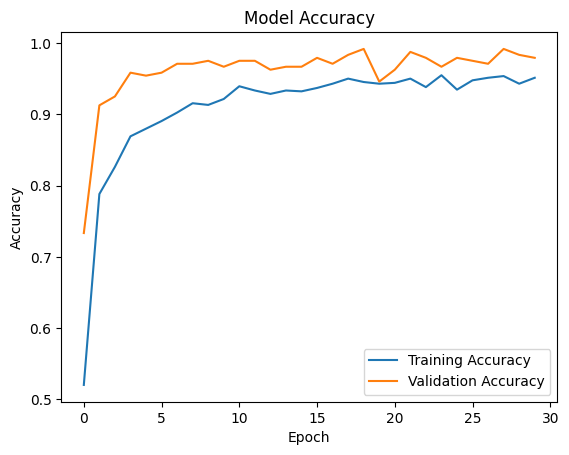

In [12]:
# 9. Visualisasi akurasi dan loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [13]:
# 10. Simpan model
model.save("model_klasifikasi_4kelas.h5")
print("Model saved!")


Model saved!
